# [How to apply LSTM using PyTorch](https://cnvrg.io/pytorch-lstm/) - Practical Implementation in PyTorch


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

plt.rcParams['figure.figsize'] = (5, 4)

In [6]:
# data file: https://www.marketwatch.com/investing/stock/sbux/download-data?startDate=1/1/2021&endDate=11/27/2024
data_file = 'C:\\Users\\stefa\\Documents\\workspaces\\szx81\\SBUX\\test_data\\SBUX0_1D_1.01.2021-27.11.2024.csv'
df = pd.read_csv(data_file, index_col = 'Date', parse_dates=True)
df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(',', '')))

df_copy = df.copy(deep=True)

testing_data_count = 50
testing_df = df_copy[testing_data_count:]
training_df = df_copy[:testing_data_count]

df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2024-11-27,100.75,102.03,100.72,101.51,4857843.0
2024-11-26,101.99,102.09,100.47,100.68,6558260.0
2024-11-25,102.93,103.32,101.78,101.84,8839592.0
2024-11-22,100.00,102.56,99.77,102.50,6563290.0
2024-11-21,99.50,100.33,98.49,100.06,6760622.0


In [7]:
df['Close']


Date
2024-11-27    101.51
2024-11-26    100.68
2024-11-25    101.84
2024-11-22    102.50
2024-11-21    100.06
               ...  
2023-12-01     99.20
2023-11-30     99.30
2023-11-29     99.85
2023-11-28    101.18
2023-11-27    102.36
Name: Close, Length: 254, dtype: float64

<Axes: title={'center': 'Star Bucks Stock "Close"'}, xlabel='Date'>

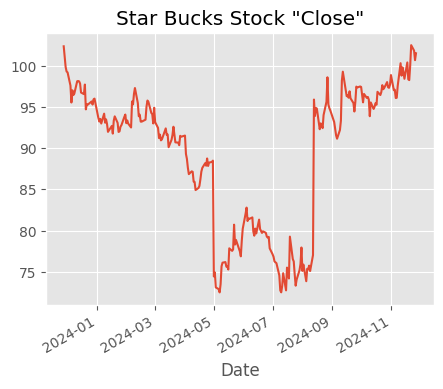

In [8]:
plt.style.use('ggplot')
df['Close'].plot(label='CLOSE', title='Star Bucks Stock "Close"')

In [35]:
def data_preprocessing(df):
    mm = MinMaxScaler()
    ss = StandardScaler()

    X_ss = ss.fit_transform(df.iloc[:, 0:]) # all columns
    y_mm = mm.fit_transform(df.iloc[:, 3:4] ) # 'Close' column
    X_tensors = Variable(torch.Tensor(X_ss))
    y_tensors = Variable(torch.Tensor(y_mm))

    X_tensors = torch.reshape(
        X_tensors,   
        (X_tensors.shape[0], 1, X_tensors.shape[1]))

    return X_tensors, y_tensors

def data_postprocessing(df, lstm1):
    mm = MinMaxScaler()
    ss = StandardScaler()

    X_ss = ss.fit_transform(df.iloc[:, 0:]) # all columns
    y_mm = mm.fit_transform(df.iloc[:, 3:4] ) # 'Close' column

    df_X_ss = ss.transform(df.iloc[:, 0:]) #old transformers
    df_y_mm = mm.transform(df.iloc[:, 3:4]) #old transformers

    df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
    df_y_mm = Variable(torch.Tensor(df_y_mm))
    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

    train_predict = lstm1(df_X_ss)#forward pass
    data_predict = train_predict.data.numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()

    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)
    plt.axvline(x=200, c='r', linestyle='--') #size of the training set

    plt.plot(dataY_plot, label='Actuall Data') #actual plot
    plt.plot(data_predict, label='Predicted Data') #predicted plot
    plt.title('Time-Series Prediction')
    plt.legend()
    plt.show() 


In [129]:
X = df.iloc[:, 0:]
# y = df.iloc[:, 5:6] 
y = df.iloc[:, 3:4] 

In [ ]:
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

In [110]:
#first 200 for training

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_mm[:200, :]
y_test = y_mm[200:, :] 

In [111]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 5) (200, 1)
Testing Shape (54, 5) (54, 1)


In [113]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [114]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(
    X_train_tensors,   
    (X_train_tensors.shape[0], 
     1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(
    X_test_tensors,  
    (X_test_tensors.shape[0], 
     1, X_test_tensors.shape[1]))

In [115]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([54, 1, 5]) torch.Size([54, 1])


In [10]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [55]:
print(LSTM1)

<class '__main__.LSTM1'>


In [11]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [13]:
X_train_tensors_final, y_train_tensors = data_preprocessing(training_df)
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [14]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [15]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [16]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.19006
Epoch: 100, loss: 0.00664
Epoch: 200, loss: 0.00355
Epoch: 300, loss: 0.00155
Epoch: 400, loss: 0.00076
Epoch: 500, loss: 0.00042
Epoch: 600, loss: 0.00022
Epoch: 700, loss: 0.00012
Epoch: 800, loss: 0.00008
Epoch: 900, loss: 0.00005


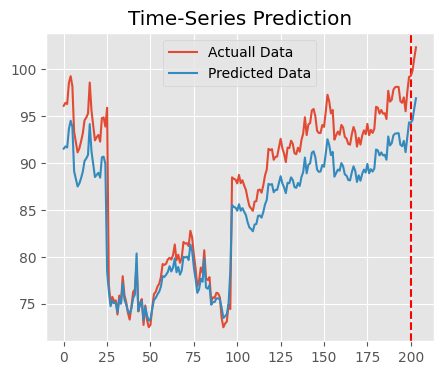

In [37]:
data_postprocessing(testing_df, lstm1)